# Adjustment Analysis

This notebook contains experiments for analyzing the drivers of whether privacy adjusted forecasts are better or worse than their original counterparts. The use of random forest and decision trees is motivated by the work of [Naghmeh et al. (2022).](https://www.sciencedirect.com/science/article/abs/pii/S0377221722002260)

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]
import os

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series

from tsfeatures import tsfeatures

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

The first step is to classify the adjusted forecasts as valuable or not (improved accuracy or not) and then extract a large number of adjustment and time series features to predict the `valuable` variable.

Start with defining the path where results will be saved, and the path to the forecast files. 

In [130]:
# results file path
results_path = "../../Outputs/Results/"
# forecasts file path
forecasts_path = "../../Outputs/Forecasts/"
# names of forecast files
fcast_files = os.listdir(forecasts_path)

Read in the train and test data for $h = 1$.

In [131]:
train_data = pd.read_csv("../../Data/Train/Clean/m3_monthly_micro_h1.csv", header=None, skiprows=1)
# convert to a list of series, and drop missing values
train_data = [x.dropna() for _, x in train_data.iterrows()]
test_data = pd.read_csv(forecasts_path + "Test_h1.csv")

We'll start with the simple exponential smoothing model.

In [132]:
original_forecasts = pd.read_csv(forecasts_path + "TES_h1_original.csv")

Read in the protected forecasts. We'll start with 10% top coding.

In [133]:
protected_forecasts = pd.read_csv(forecasts_path + "SES_h1_Top_0.1.csv")

## Dependent Variable

Calculate whether each adjustment was valuable or not. This will be the dependent variable in our analysis.

In [134]:
original_errors = mean_absolute_error(test_data, original_forecasts, multioutput="raw_values")

In [135]:
adjusted_errors = mean_absolute_error(test_data, protected_forecasts, multioutput="raw_values")

In [136]:
valuable = adjusted_errors < original_errors

## Independent Variables

Here, we will calculate various independent variables to help us understand when and why privacy protection results in adjustments that improve (degrade) accuracy. We will have two classes of variables:

* adjustment variables (direction, magnitude, etc.)
* time series variables (characteristics of the original time series that could determine the adjustment outcome)

### Adjustment Variables

Calculate adjustment direction (binary variable).

In [137]:
direction = (protected_forecasts > original_forecasts).T

Calculate adjustment magnitude (absolute difference in forecasts), normalized by the mean of the series.

In [138]:
series_means = [np.mean(x) for x in train_data]

In [139]:
magnitudes = (protected_forecasts - original_forecasts).abs().T.divide(series_means, axis=0)

Calculate binary large and small adjustment indicators (belongs to 4th and 1st quantiles, respectively).

In [140]:
qs = np.quantile(magnitudes, q=[0.25, 0.75])

In [141]:
large_magnitudes = magnitudes >= qs[1]

In [142]:
small_magnitudes = magnitudes <= qs[0]

### Time Series Variables

We use the `tsfeatures` package in R to extract various time series features. We read in the feature data here.

In [143]:
ts_features = pd.read_csv("../../Data/Train/Clean/tsfeatures_h1_top_outliers.csv")

In [144]:
ts_features

,cv,Outlier_within_1,Outlier_within_5,Outlier_within_10,entropy,nperiods,seasonal_period,trend,spike,linearity,...,peak,trough,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,nonlinearity
0,0.088761,0,0,0,0.968297,1,12,0.273043,6.331846e-05,-1.845781,...,8,5,0.052854,0.248734,-0.517455,0.399985,-0.623449,0.534498,-0.067831,0.023815
1,0.114949,0,0,0,1.000000,1,12,0.121518,1.447315e-04,0.026279,...,8,3,-0.054612,0.126025,-0.505619,0.357214,-0.649181,0.606947,-0.006173,0.044383
2,0.063198,0,0,0,0.921274,1,12,0.453304,1.277966e-05,2.494889,...,11,9,0.223757,0.508861,-0.485173,0.368154,-0.614741,0.550538,0.070814,0.231680
3,0.117608,0,0,0,0.755972,1,12,0.647523,5.183499e-05,5.588990,...,11,7,0.467665,1.762905,-0.589694,0.670926,-0.714714,1.024441,0.283559,1.217131
4,0.069445,0,0,0,0.904561,1,12,0.522140,1.394859e-05,2.941030,...,11,10,0.237771,0.618326,-0.527752,0.306114,-0.665029,0.539983,0.154327,1.018855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.010099,0,0,0,0.800102,1,12,0.596488,1.805620e-09,0.643690,...,9,6,0.474108,1.579949,-0.503721,0.336730,-0.678628,0.617587,0.394315,0.256836
470,0.002642,0,0,0,0.969237,1,12,0.394765,1.056742e-11,-0.072545,...,9,6,0.378460,0.356983,-0.387688,0.192081,-0.616377,0.422467,0.307508,0.221978
471,0.009194,0,0,0,0.941356,1,12,0.436740,1.697291e-09,-0.338446,...,5,1,0.345019,0.619854,-0.450693,0.295367,-0.620059,0.487845,0.234009,0.234213
472,0.001878,0,0,0,0.978673,1,12,0.194416,1.745082e-11,0.013147,...,5,3,0.028853,0.128958,-0.476860,0.467550,-0.611028,0.669871,-0.147511,0.145142


In [145]:
ts_features = ts_features.loc[:, ["entropy", "x_acf1", "trend", "seasonal_strength"]]

In [36]:
# ts_features = ts_features.drop(["nperiods", "seasonal_period"], axis=1).reset_index(drop=True)

In [ ]:
# train_df = pd.DataFrame(train_data)
# train_df['series'] = train_df.index

In [ ]:
# train_df = pd.melt(train_df, id_vars="series").sort_values(["series", "variable"]).dropna().reset_index(drop=True)

In [ ]:
# train_df.columns = ["unique_id", "ds", "y"]

In [ ]:
# train_df

Define the data frequency (monthly data).

In [ ]:
# freq = 12

Basic `tsfeatures`.

In [ ]:
# series_features = tsfeatures(train_df, freq=freq)

In [ ]:
# series_features

In [ ]:
# ts_features = series_features.dropna(axis=1)

In [ ]:
# ts_features = ts_features.drop(["unique_id", "series_length", "nperiods", "seasonal_period"], axis=1).reset_index(drop=True)

### Combining Features

We have our target variable, `valuable`.

We need to combine our predictor variables.

In [146]:
X = pd.concat([direction, magnitudes, large_magnitudes, small_magnitudes], axis=1, ignore_index=True).reset_index(drop=True)

In [147]:
X.columns = ["Direction", "Magnitude", "Large_Magnitude", "Small_Magnitude"]

In [148]:
X = pd.concat([X, ts_features], axis=1)

In [22]:
X = ts_features

In [149]:
scaler = StandardScaler()

In [150]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [151]:
X_scaled

,Direction,Magnitude,Large_Magnitude,Small_Magnitude,entropy,x_acf1,trend,seasonal_strength
0,1.083657,0.012354,-0.578974,-0.578974,0.876022,-1.147715,-0.889291,-1.570275
1,1.083657,1.175888,1.727192,-0.578974,1.014251,-1.517188,-1.485975,-0.970064
2,-0.922801,1.679574,1.727192,-0.578974,0.670999,-0.560141,-0.179450,-1.294574
3,1.083657,0.449874,1.727192,-0.578974,-0.049735,0.278429,0.585361,-0.900646
4,-0.922801,2.579140,1.727192,-0.578974,0.598128,-0.511959,0.091620,-0.100939
...,...,...,...,...,...,...,...,...
469,-0.922801,-0.321164,-0.578974,-0.578974,0.142674,0.300581,0.384390,-0.572003
470,1.083657,-0.693558,-0.578974,1.727192,0.880123,-0.028263,-0.409965,0.431763
471,-0.922801,-0.238575,-0.578974,-0.578974,0.758557,-0.143236,-0.244675,-0.601936
472,-0.922801,-0.647907,-0.578974,1.727192,0.921261,-1.230231,-1.198916,-1.711329


## Predicting Adjustment Value Using Random Forest

In [158]:
RF = RandomForestClassifier()

In [159]:
RF.fit(X_scaled, valuable)

RandomForestClassifier()

In [160]:
RF.score(X_scaled, valuable)

1.0

In [161]:
result = permutation_importance(RF, X_scaled, valuable, n_repeats=100)

In [162]:
importances = pd.Series(result.importances_mean, index=X_scaled.columns)

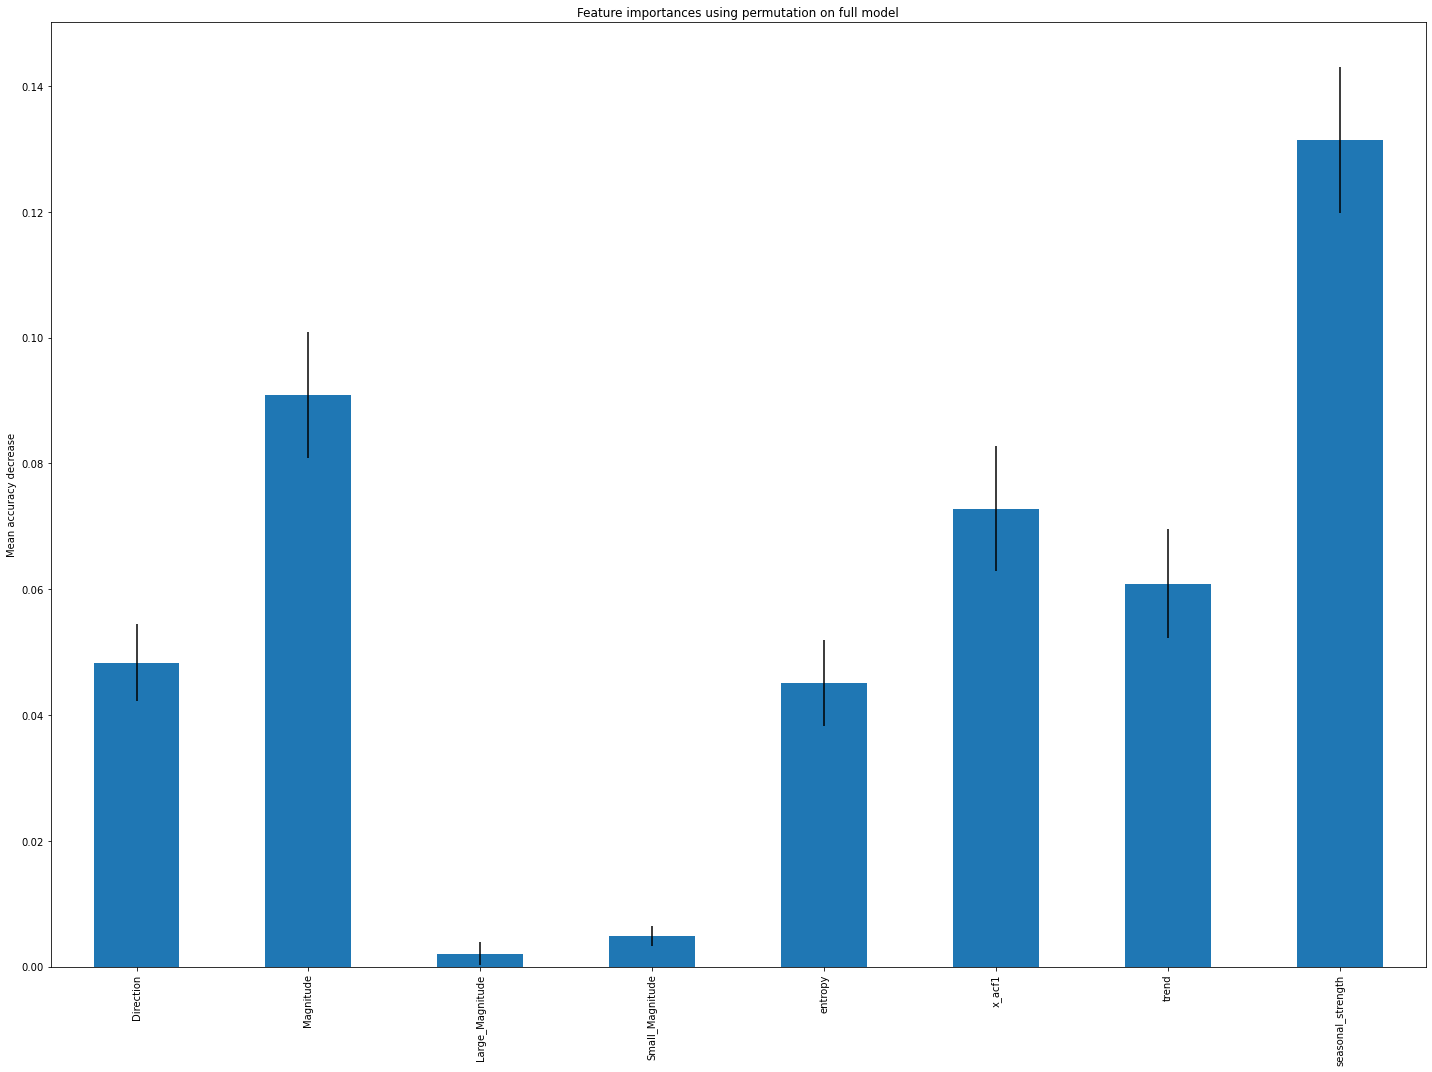

In [163]:
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticklabels(X_scaled.columns)
fig.tight_layout()
plt.show()

## Explaining Adjustment Value Using Decision Tree

In [181]:
DT = DecisionTreeClassifier(max_depth=3)

In [182]:
dt_features = ["seasonal_strength", "x_acf1", "Magnitude", "Direction"]

In [183]:
dt_results = DT.fit(X_scaled.loc[:,dt_features], valuable)

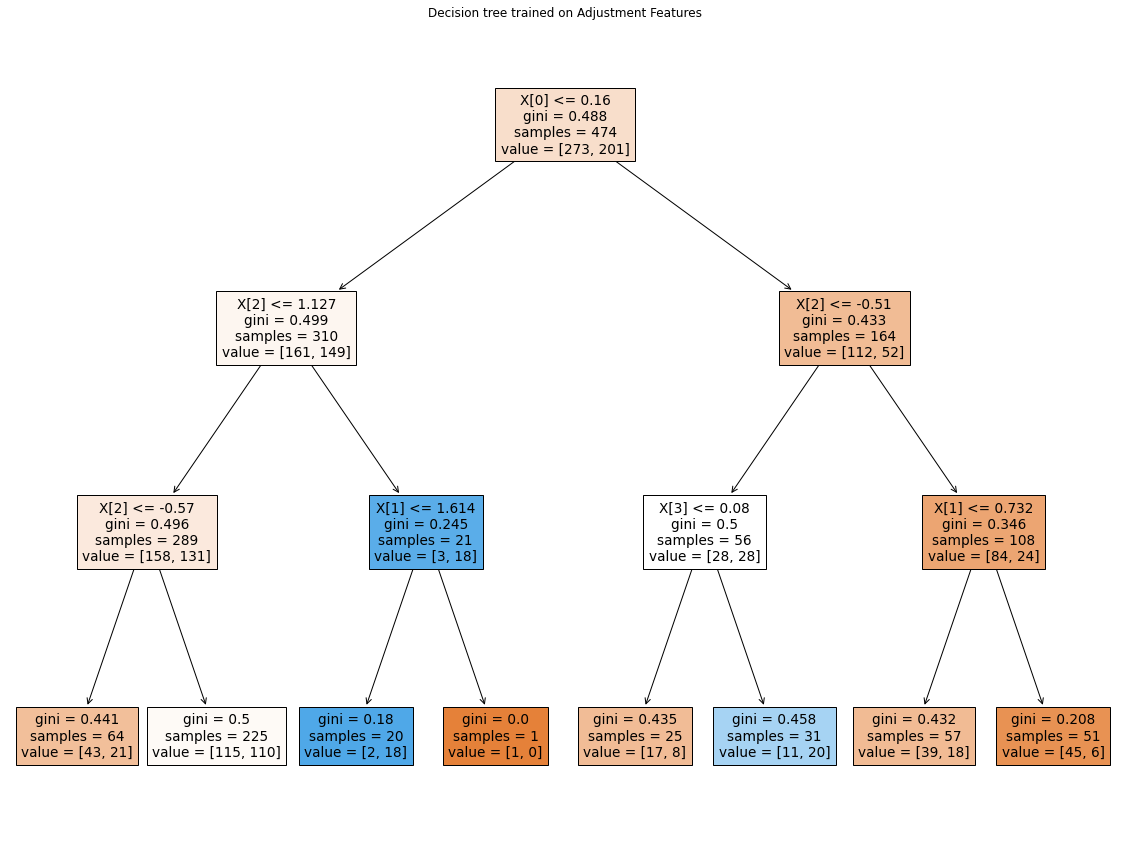

In [184]:
plt.figure()
plot_tree(DT, filled=True)
plt.title("Decision tree trained on Adjustment Features")
plt.show()

Assess the characteristics of series in the most pure leaves.

In [167]:
leaf_indices = DT.apply(X_scaled.loc[:,dt_features])

In [168]:
leaf_index = 4

In [169]:
leaf_series_indices = [i for i,x in enumerate(leaf_indices) if (x == leaf_index) and (valuable[i] == 1.0)]

Now, examine the time series features for these series.

In [170]:
ts_features.loc[leaf_series_indices,:]

,entropy,x_acf1,trend,seasonal_strength
3,0.755972,0.467665,0.647523,0.241784
6,1.000000,0.025111,0.210406,0.193966
17,0.963008,0.111933,0.297094,0.349371
19,0.855926,0.504327,0.619078,0.320210
21,0.825944,0.447066,0.570586,0.243200
...,...,...,...,...
459,0.808608,0.369097,0.582807,0.337650
460,0.909325,0.363757,0.518175,0.270263
461,0.684092,0.529699,0.648940,0.255051
471,0.941356,0.345019,0.436740,0.285119


***

In [174]:
unique_leaf_indices = np.unique(leaf_indices)

In [175]:
unique_leaf_indices

array([ 3,  4,  6,  7, 10, 11, 13, 14], dtype=int64)

In [172]:
leaves = []
for i in unique_leaf_indices:
    leaves.append(X.loc[leaf_indices==i,:]) 

In [173]:
leaf_means = [x.mean(axis=0) for x in leaves]

In [189]:
leaf_means[2].values.round(2)

array([0.35, 0.42, 1.  , 0.  , 0.84, 0.27, 0.41, 0.29])

In [190]:
leaf_means[7].values.round(2)

array([0.16, 0.19, 0.37, 0.  , 0.52, 0.7 , 0.74, 0.59])

In [ ]:
lea

In [96]:
leaf_index = 13

In [97]:
leaf_series_indices = [i for i,x in enumerate(leaf_indices) if (x == leaf_index) and (valuable[i] != 1.0)]

Now, examine the time series features for these series.

In [98]:
ts_features.loc[leaf_series_indices,:]

,entropy,x_acf1,trend,seasonal_strength
79,0.698473,0.636202,0.792617,0.434263
87,0.673335,0.713395,0.871563,0.467736
89,0.777464,0.365718,0.628946,0.447021
99,0.604835,0.612474,0.758872,0.453003
101,0.894762,0.422982,0.631937,0.484643
160,0.667195,0.731196,0.860711,0.411843
170,0.740740,0.506933,0.760020,0.610157
198,0.787019,0.649628,0.776185,0.423225
246,0.665122,0.687118,0.825097,0.591971
248,0.706269,0.625328,0.737259,0.583177


***

In [73]:
leaf_series = [train_data[i] for i,x in enumerate(leaf_indices) if x == leaf_index]

In [74]:
leaf_values = [valuable[i] for i,x in enumerate(leaf_indices) if x == leaf_index]

In [75]:
improved_accuracy = [leaf_series[i] for i,x in enumerate(leaf_values) if x]

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='5'>)

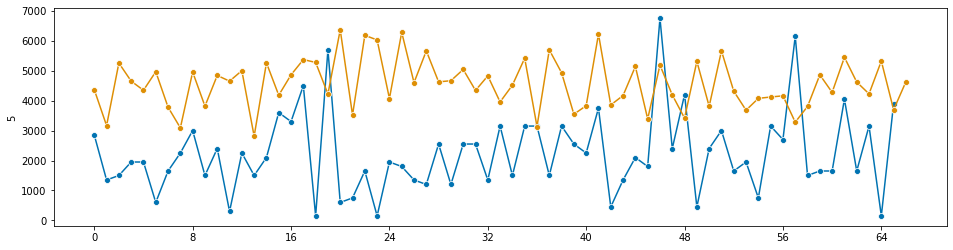

In [76]:
plot_series(improved_accuracy[0], improved_accuracy[1])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='45'>)

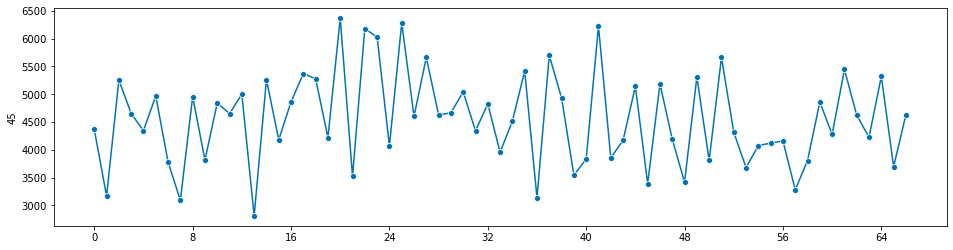

In [77]:
plot_series(improved_accuracy[1])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='225'>)

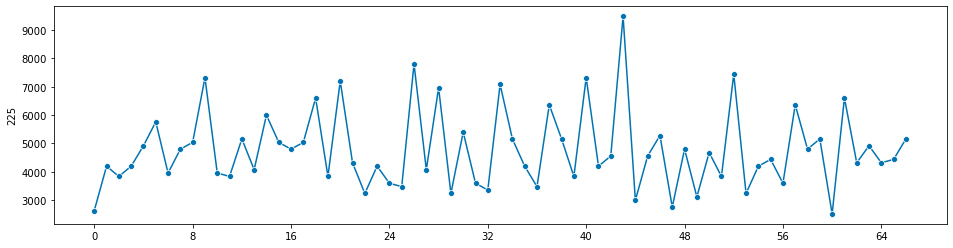

In [78]:
plot_series(improved_accuracy[2])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='241'>)

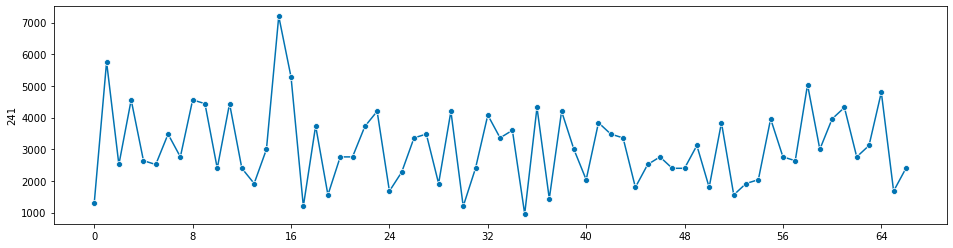

In [79]:
plot_series(improved_accuracy[3])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='259'>)

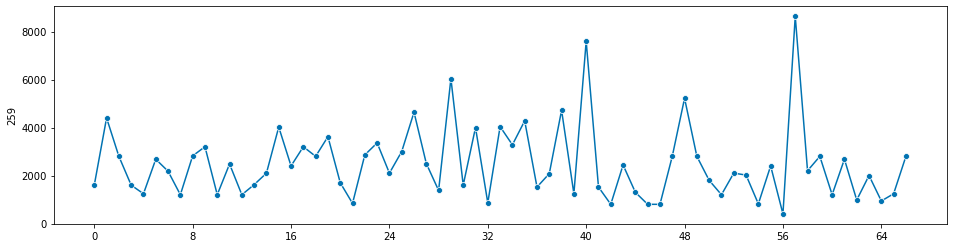

In [80]:
plot_series(improved_accuracy[4])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='260'>)

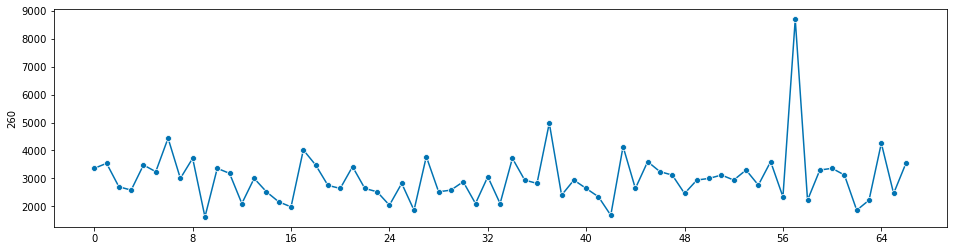

In [81]:
plot_series(improved_accuracy[5])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='263'>)

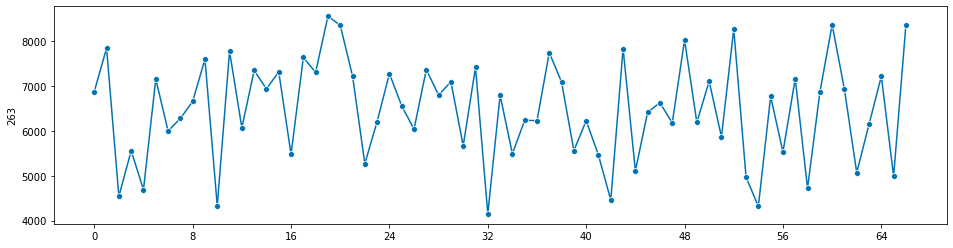

In [82]:
plot_series(improved_accuracy[6])